In [1]:
#reduced data
import pandas as pd

# Load the dataset with a different encoding
df = pd.read_csv('reviews_0-250.csv', encoding='ISO-8859-1')

# Define good, bad, and neutral comments
def classify_sentiment(rating):
    if rating >= 4:
        return 'good'
    elif rating <= 2:
        return 'bad'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(classify_sentiment)

# Group by 'product_name' and 'sentiment' and find the minimum size for each product
grouped = df.groupby(['product_name', 'sentiment']).size().unstack(fill_value=0)
grouped['min_size'] = grouped.min(axis=1)

# Sample each group to the size of the smallest group for each product
sampled_df_list = []
for product, min_size in grouped['min_size'].items():
    good_comments = df[(df['product_name'] == product) & (df['sentiment'] == 'good')].sample(min_size)
    bad_comments = df[(df['product_name'] == product) & (df['sentiment'] == 'bad')].sample(min_size)
    neutral_comments = df[(df['product_name'] == product) & (df['sentiment'] == 'neutral')].sample(min_size)
    sampled_df_list.append(pd.concat([good_comments, bad_comments, neutral_comments]))

# Combine all the sampled data
sampled_df = pd.concat(sampled_df_list).reset_index(drop=True)

# Save the reduced dataset to a new CSV file
output_path = 'reduced_dataset.csv'
sampled_df.to_csv(output_path, index=False)

/tmp/ipykernel_158859/3125455414.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('reviews_0-250.csv', encoding='ISO-8859-1')


/tmp/ipykernel_3940032/3524399529.py:6: DtypeWarning: Columns (0,1,4,6,7,8,9,10,11,12,13,14,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('reduced_dataset.csv')


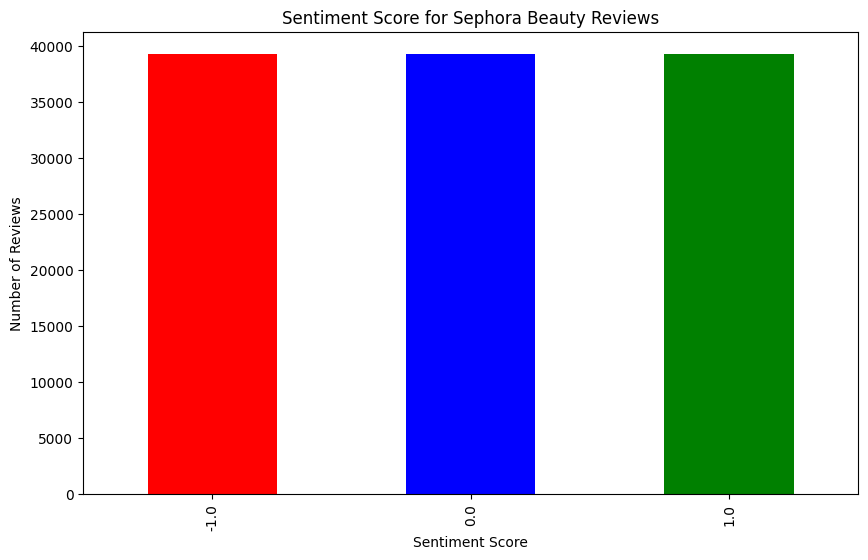

In [2]:
#sentiment score for sephora beauty reviews
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('reduced_dataset.csv')

# Map sentiment to numerical scores
sentiment_mapping = {'good': 1, 'neutral': 0, 'bad': -1}
data['sentiment_score'] = data['sentiment'].map(sentiment_mapping)

# Plotting the sentiment scores
plt.figure(figsize=(10, 6))

# Count the occurrences of each sentiment score
sentiment_counts = data['sentiment_score'].value_counts().sort_index()

# Bar plot
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])

# Add titles and labels
plt.title('Sentiment Score for Sephora Beauty Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')

# Show the plot
plt.show()

/tmp/ipykernel_3940032/1506587355.py:11: DtypeWarning: Columns (0,1,4,6,7,8,9,10,11,12,13,14,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('reduced_dataset.csv')
[nltk_data] Downloading package stopwords to /home/yatipa/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


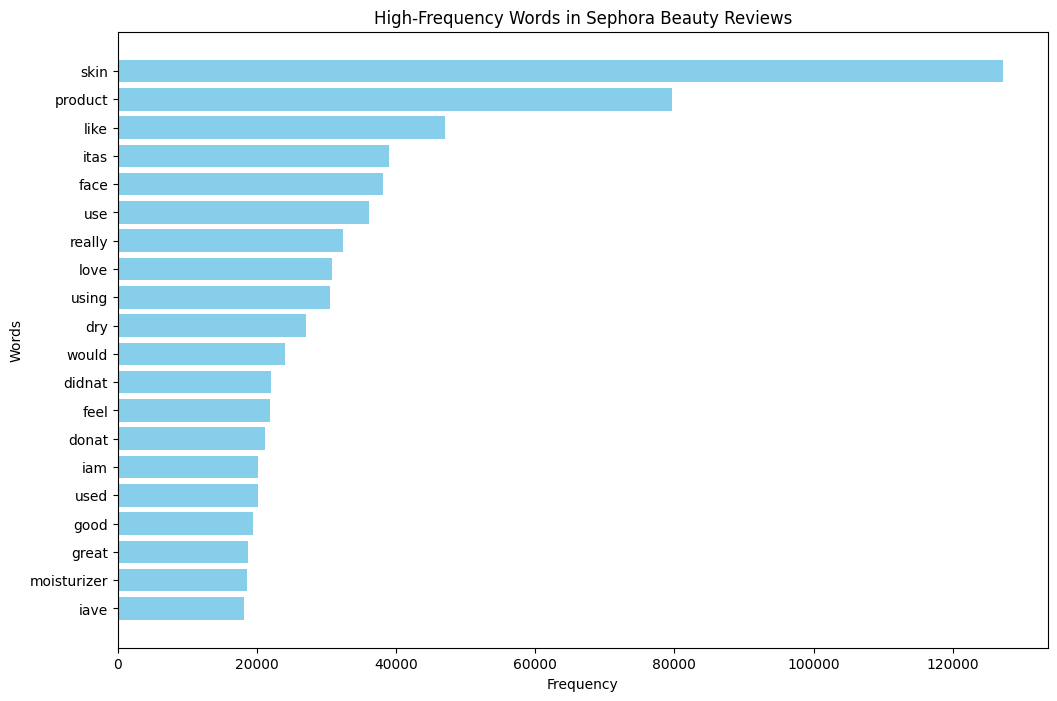

In [4]:
#high frequent words in all reviews
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import matplotlib.pyplot as plt
from unidecode import unidecode

# Read the data
# data = pd.read_csv('reduced_dataset.csv')

# Download NLTK stopwords
nltk.download('stopwords')

# Combine all review texts into one string
all_reviews = ' '.join(data['review_text'].dropna().astype(str))

# Function to clean and tokenize text
def clean_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to ASCII
    text = unidecode(text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Get the tokens
tokens = clean_tokenize(all_reviews)

# Count word frequencies
word_counts = Counter(tokens)

# Get the most common words
most_common_words = word_counts.most_common(20)  # Adjust number as needed

# Convert to DataFrame for plotting
word_freq_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

# Plotting the high-frequency words
plt.figure(figsize=(12, 8))

# Bar plot
plt.barh(word_freq_df['word'], word_freq_df['frequency'], color='skyblue')

# Add titles and labels
plt.title('High-Frequency Words in Sephora Beauty Reviews')
plt.xlabel('Frequency')
plt.ylabel('Words')

# Show the plot
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

[nltk_data] Downloading package stopwords to /home/yatipa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


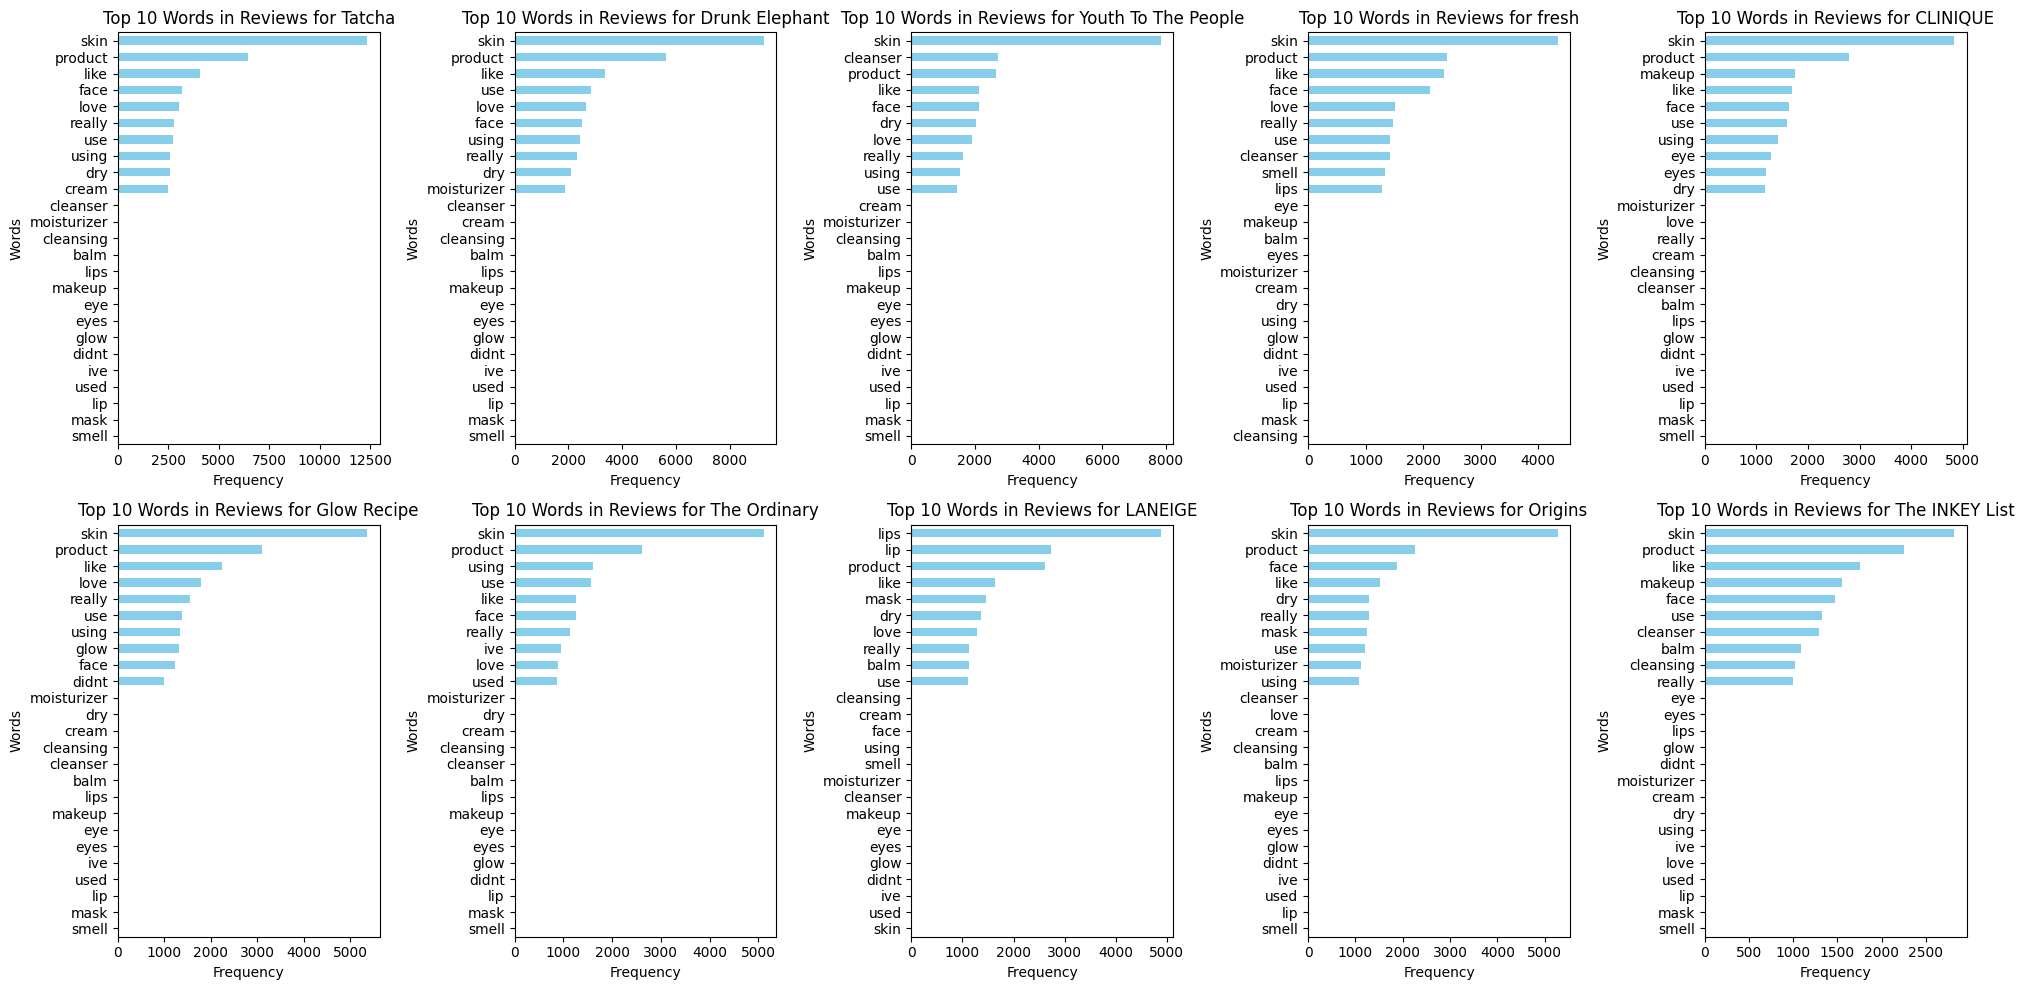

In [5]:
#most common words in reviews by top 10 brand
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import matplotlib.pyplot as plt

# Read the data
# data = pd.read_csv('reduced_dataset.csv')

# Count the number of reviews per brand
top_brands = data['brand_name'].value_counts().head(10)

# Download NLTK stopwords
nltk.download('stopwords')

def clean_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if char in string.printable])  # Remove non-ASCII characters
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Prepare a dictionary to store word frequencies for each brand
brand_word_counts = {}

for brand in top_brands.index:
    brand_reviews = ' '.join(data[data['brand_name'] == brand]['review_text'].dropna().astype(str))
    tokens = clean_tokenize(brand_reviews)
    word_counts = Counter(tokens)
    brand_word_counts[brand] = word_counts.most_common(10)

# Convert the dictionary to a DataFrame for easier plotting
word_freq_df = pd.DataFrame({
    brand: dict(word_counts) for brand, word_counts in brand_word_counts.items()
}).fillna(0).astype(int)

# Plotting the high-frequency words for each brand
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = axes.flatten()

for i, brand in enumerate(word_freq_df.columns):
    ax = axes[i]
    word_freq_df[brand].sort_values().plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title(f'Top 10 Words in Reviews for {brand}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')

# Hide any unused subplots
for i in range(len(word_freq_df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [6]:
#word cloud in each brand (top 10)
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('reduced_dataset.csv')

# Count the number of reviews per brand
top_brands = data['brand_name'].value_counts().head(10)

# Download NLTK stopwords
nltk.download('stopwords')

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters
    text = ''.join([char for char in text if char in string.printable])
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Join tokens back to string
    return ' '.join(tokens)

# Generate word clouds for the top 10 brands
plt.figure(figsize=(20, 25))

for i, brand in enumerate(top_brands.index, 1):
    # Combine all reviews for the brand
    brand_reviews = ' '.join(data[data['brand_name'] == brand]['review_text'].dropna().astype(str))
    clean_reviews = clean_text(brand_reviews)
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(clean_reviews)
    
    # Plot the word cloud
    plt.subplot(5, 2, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {brand}', fontsize=16)
    plt.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
#price impact on positive/negative comments
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
# data = pd.read_csv('reduced_dataset.csv')

# Categorize reviews as positive or negative based on the sentiment column
data['sentiment_category'] = data['sentiment'].apply(lambda x: 'positive' if x == 'good' else 'negative')

# Calculate the average price of products associated with positive and negative reviews
average_price = data.groupby('sentiment_category')['price_usd'].mean()

# Plotting the average prices for positive and negative reviews
average_price.plot(kind='bar', figsize=(10, 6), color=['green', 'red'])

# Add titles and labels
plt.title('Average Price of Products for Positive and Negative Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Average Price (USD)')

# Show the plot
plt.show()

In [ ]:
#negative/positive reviews in each brand (top 10)
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
# data = pd.read_csv('reduced_dataset.csv')

# Count the number of reviews per brand
top_brands = data['brand_name'].value_counts().head(10)

# Categorize reviews as positive or negative based on the sentiment column
data['sentiment_category'] = data['sentiment'].apply(lambda x: 'positive' if x == 'good' else 'negative')

# Count the number of positive and negative reviews for each of the top 10 brands
brand_sentiment_counts = data[data['brand_name'].isin(top_brands.index)].groupby(['brand_name', 'sentiment_category']).size().unstack(fill_value=0)

# Plotting the positive and negative reviews for each brand
brand_sentiment_counts.plot(kind='bar', stacked=True, figsize=(14, 8), color=['red', 'green'])

# Add titles and labels
plt.title('Number of Positive and Negative Reviews for Top 10 Brands')
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')

# Show the plot
plt.show()

In [ ]:
#price impact on positive/negative comments
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
# data = pd.read_csv('reduced_dataset.csv')

# Categorize reviews as positive or negative based on the sentiment column
data['sentiment_category'] = data['sentiment'].apply(lambda x: 'positive' if x == 'good' else 'negative')

# Calculate the average price of products associated with positive and negative reviews
average_price = data.groupby('sentiment_category')['price_usd'].mean()

# Plotting the average prices for positive and negative reviews
average_price.plot(kind='bar', figsize=(10, 6), color=['green', 'red'])

# Add titles and labels
plt.title('Average Price of Products for Positive and Negative Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Average Price (USD)')

# Show the plot
plt.show()

In [ ]:
#time series analysis(analyze the sentiment trend over time for reviews)
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset with a different encoding
df = pd.read_csv('reviews_0-250_new.csv', encoding='ISO-8859-1')

# Define good, bad, and neutral comments
def classify_sentiment(rating):
    if rating >= 4:
        return 'good'
    elif rating <= 2:
        return 'bad'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(classify_sentiment)

# Group by 'product_name' and 'sentiment' and find the minimum size for each product
grouped = df.groupby(['product_name', 'sentiment']).size().unstack(fill_value=0)
grouped['min_size'] = grouped.min(axis=1)

# Sample each group to the size of the smallest group for each product
sampled_df_list = []
for product, min_size in grouped['min_size'].iteritems():
    good_comments = df[(df['product_name'] == product) & (df['sentiment'] == 'good')].sample(min_size)
    bad_comments = df[(df['product_name'] == product) & (df['sentiment'] == 'bad')].sample(min_size)
    neutral_comments = df[(df['product_name'] == product) & (df['sentiment'] == 'neutral')].sample(min_size)
    sampled_df_list.append(pd.concat([good_comments, bad_comments, neutral_comments]))

# Combine all the sampled data
sampled_df = pd.concat(sampled_df_list).reset_index(drop=True)

# Save the reduced dataset to a new CSV file
output_path = 'reduced_dataset(1).csv'
sampled_df.to_csv(output_path, index=False)

# Read the data
data = pd.read_csv('reduced_dataset(1).csv')

# Inspect column names
print(data.columns)

# the date column name is 'submission_time'
data['submission_time'] = pd.to_datetime(data['submission_time'])

# Categorize reviews as positive or negative based on the sentiment column
data['sentiment_category'] = data['sentiment'].apply(lambda x: 'positive' if x == 'good' else 'negative')

# Group by date and sentiment category, then count the number of reviews per group
sentiment_trend = data.groupby([data['submission_time'].dt.to_period('M'), 'sentiment_category']).size().unstack(fill_value=0)

# Convert the period index back to a datetime index for plotting
sentiment_trend.index = sentiment_trend.index.to_timestamp()

# Plotting the time series of sentiment trends
plt.figure(figsize=(14, 8))

# Plot positive sentiment trend
plt.plot(sentiment_trend.index, sentiment_trend['positive'], label='Positive', color='green')

# Plot negative sentiment trend
plt.plot(sentiment_trend.index, sentiment_trend['negative'], label='Negative', color='red')

# Add titles and labels
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')

# Show the plot
plt.show()

In [ ]:
#Sentiment Distribution by Category (Show the distribution of sentiment scores across different product categories.) Top 10 product
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
data = pd.read_csv('reduced_dataset.csv')

# 'sentiment' column contains categorical sentiment labels ('good', 'neutral', 'bad')
# Convert sentiment labels to numeric scores for plotting purposes
sentiment_scores = {'good': 3, 'neutral': 2, 'bad': 1}  # Define mapping of sentiment labels to scores
data['sentiment_score'] = data['sentiment'].map(sentiment_scores)

# Identify top 10 products with the most reviews
top_products = data['product_name'].value_counts().nlargest(10).index

# Filter data to include only top products
filtered_data = data[data['product_name'].isin(top_products)]

# Plotting a box plot to show sentiment distribution by top products
plt.figure(figsize=(12, 8))

# Customize colors for each category
colors = sns.color_palette("Set3", len(top_products))

# Create the box plot
sns.boxplot(data=filtered_data, x='product_name', y='sentiment_score', palette=colors)

# Add titles and labels
plt.title('Sentiment Distribution by Top 10 Products')
plt.xlabel('Product Name')
plt.ylabel('Sentiment Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#LSTM
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns
import re
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Load the reduced dataset
df = pd.read_csv('reduced_dataset.csv')

# Preprocess the data
df['review_text'].fillna('', inplace=True)

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-English characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
df['cleaned_review_text'] = df['review_text'].apply(clean_text)

# Function to detect language and filter out non-English reviews
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Filter out non-English reviews
df = df[df['cleaned_review_text'].apply(is_english)]

# Encode the labels
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Tokenize the cleaned text data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_review_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review_text'])

# Pad the sequences
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'], test_size=0.3, random_state=42)

# Load GloVe embeddings
def load_glove_embeddings(filepath, word_index, embedding_dim=300):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Use the 300-dimensional GloVe embeddings
glove_filepath = 'glove.42B.300d.txt'
embedding_dim = 300
embedding_matrix = load_glove_embeddings(glove_filepath, tokenizer.word_index, embedding_dim)

# Build the model with GloVe embeddings
def build_model_with_glove():
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.7),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.7),
        Bidirectional(LSTM(32)),
        Dropout(0.7),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model_with_glove()

# Hyperparameters
epochs = 25
batch_size = 256

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Predict probabilities
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes